# Testes de Desempenho

## K-Means

Vamos agora realizar testes de ganho de velocidade de execução, comparando o desempenho do K-Means rodando na CPU com o do K-means rodando na GPU.

Desta vez, iremos utilizar datasets bem maiores e, portanto, nada triviais — como era o caso do [*Iris* Data Set](https://archive.ics.uci.edu/ml/datasets/Iris) que foi usado anteriormente apenas como uma prova de conceito e teste de corretude.

A ideia é testar se os ganhos de desempenho ao utilizarmos uma versão paralelizada em GPU diminuem, estagnam ou aumentam junto com o aumento de instâncias ou dimensionalidade do dataset.

Também será testado se houve diferença de precisção de cada classificação. Isso é realizado usando a função `getClassificationHits()`, explicada mais a fundo nos cadernos Jupyter `kMeansCPU.ipynb` e `kMeansGPU.ipynb`.

### Código Comum

In [130]:
import kMeans as km
import pandas as pd

import time
import os

import importlib
importlib.reload(km)

# Testing imports
print(km.kMeansCPU)
print(km.kMeansGPU)
print(km.getClassificationHits)

# Se verdadeiro, os testes incluirão a contagem de acertos dos resultados dos algoritmos. Isso pode demorar MUITO (>5h por execução no dataset 5)!
TEST_CORRECTEDNESS = False

# Valor efetivamente infinito para um float, para ser usado como valor inicial na variável "fastestExecTime"
FLOAT_MAX = float('inf')

# Configurando Numba para não reportar erros de baixa ocupação dos streaming multiprocessors (SMs) da GPU
# Não suprimir estes erros gera um overhead bem considerável, ocasionalmente, em algumas execuções do K-Means GPU
%set_env NUMBA_CUDA_LOW_OCCUPANCY_WARNINGS 0

# Função para rodar os testes
def runTests(mode:str='GPU', runs:int=10, countHits:bool=True):
    '''Essa função depende de diversas variáveis declaradas anteriormente. Portanto, é inútil fora deste caderno Jupyter!'''

    mode = mode.upper()
    if mode == 'CPU': kMeans = km.kMeansCPU
    elif mode == 'GPU': kMeans = km.kMeansGPU
    else: raise ValueError('Unknown mode!')

    totalExecTime = 0.0
    slowestExecTime = -1.0
    fastestExecTime = FLOAT_MAX

    totalHits = 0
    totalHitsTime = 0.0

    for rep in range(1, runs + 1):
        startTime = time.perf_counter()
        results = kMeans(datasetTreated, k=K, maxIter=MAX_ITERATIONS, printIter=False, plotResults=PLOT_RESULTS, debug=DEBUG)
        elapsedTime = time.perf_counter() - startTime
        if elapsedTime < fastestExecTime: fastestExecTime = elapsedTime
        if elapsedTime > slowestExecTime: slowestExecTime = elapsedTime
        totalExecTime += elapsedTime
        print(f'Execution K-Means {mode} run #{rep}: {elapsedTime}; curr avg: {totalExecTime / rep}; ', end='')

        if countHits:
            # Verificando acertos
            # Converting from numpy arrays to panda's dataframes, if needed
            if results.__class__.__name__ != pd.DataFrame.__class__.__name__: results = pd.DataFrame(results)
            startTime = time.perf_counter()
            hits, _, _  = km.getClassificationHits(results, dataset, classColumnName, classes, debug=DEBUG)
            elapsedTime = time.perf_counter() - startTime
            totalHits += hits
            totalHitsTime += elapsedTime
            print(f'Hits: {hits} (done in {elapsedTime:.4f}); curr avg hits: {totalHits / rep}', end='')

        print('\n', end='')

    print(f' \nAvg exec K-Means {mode}: {totalExecTime / runs}')
    print(f'Max exec K-Means {mode}: {slowestExecTime}')
    print(f'Min exec time K-Means {mode}: {fastestExecTime}')

    if countHits:
        print(f' \nAverage hits: {totalHits / runs}')
        print(f'Avg exec K-Means {mode} classificationHits(): {totalHitsTime / runs}')

<function kMeansCPU at 0x719967c2cd60>
<function kMeansGPU at 0x719967c2c680>
<function getClassificationHits at 0x7199676785e0>
env: NUMBA_CUDA_LOW_OCCUPANCY_WARNINGS=0


### Dataset 1 (N > 1.000, D = 7, K = 2) — Rice (Cammeo and Osmancik)

Foi utilizado aqui o Dataset **[Rice (Cammeo and Osmancik)](https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik)**, que reúne dados expressando características morfológicas de grãos de arroz de duas espécies, extraídas a partir de fotos destes. Temos **7 variáveis (D = 7)** e **3.810 instâncias**.

Esse dataset também contém informações de classe, definindo qual a espécie real do grão de arroz: **Cammeo** ou **Osmancik**. Portanto, haverão **2 grupos de dados (K = 2)**.

Esse conjunto de dados está presente no arquivo `Rice_Cammeo_Osmancik.arff` dentro do arquivo `rice+cammeo+and+osmancik.zip` do dataset (também disponível em download direto [neste link](https://archive.ics.uci.edu/static/public/545/rice+cammeo+and+osmancik.zip)).

#### Código

In [131]:
# Novas variáveis globais
K = 2
MAX_ITERATIONS = 60
PLOT_RESULTS = False
DEBUG = False

COMMENT_CHAR = '%'
ALTERNATIVE_COMMENT_CHARS = ['@']

datasetFilePath = './Rice_Cammeo_Osmancik.csv'

# Processando o aqruivo .arff file e convertendo para um arquivo .csv válido (com linhas comentadas)
if not os.path.exists(datasetFilePath):
    with \
        open('./rice+cammeo+and+osmancik/Rice_Cammeo_Osmancik.arff', 'r') as file,\
        open(datasetFilePath, 'w') as fileNew:

        for line in file:
            if line[0] in ALTERNATIVE_COMMENT_CHARS:
                fileNew.write(COMMENT_CHAR + ' ' + line[1:])
            else:
                fileNew.write(line)

columnNames = ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent', 'Class']

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames, sep=',', skip_blank_lines=True, comment=COMMENT_CHAR)

datasetTreated = dataset.drop(columns=['Class'])
print(datasetTreated)

classColumnName = 'Class'
classes = dataset[classColumnName].unique()

print(f'Classes (from column "{classColumnName}"): {classes}')

       Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity   
0     15231  525.578979         229.749878          85.093788      0.928882  \
1     14656  494.311005         206.020065          91.730972      0.895405   
2     14634  501.122009         214.106781          87.768288      0.912118   
3     13176  458.342987         193.337387          87.448395      0.891861   
4     14688  507.166992         211.743378          89.312454      0.906691   
...     ...         ...                ...                ...           ...   
3805  11441  415.858002         170.486771          85.756592      0.864280   
3806  11625  421.390015         167.714798          89.462570      0.845850   
3807  12437  442.498993         183.572922          86.801979      0.881144   
3808   9882  392.296997         161.193985          78.210480      0.874406   
3809  11434  404.709991         161.079269          90.868195      0.825692   

      Convex_Area    Extent  
0           15617  0.

In [132]:
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((datasetTreated - datasetTreated.min()) / (datasetTreated.max() - datasetTreated.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
          Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity   
0     7.083436   8.913085           9.110943           5.791756      8.992095  \
1     6.627970   7.426854           6.832784           7.035968      7.227819   
2     6.610544   7.750595           7.609142           6.293120      8.108617   
3     5.455642   5.717221           5.615196           6.233153      7.041041   
4     6.653318   8.037925           7.382246           6.582591      7.822599   
...        ...        ...                ...                ...           ...   
3805  4.081324   3.697823           3.421444           5.916006      5.587521   
3806  4.227073   3.960771           3.155323           6.610732      4.616211   
3807  4.870269   4.964124           4.677767           6.111975      6.476267   
3808  2.846418   2.577921           2.529299           4.501406      6.121153   
3809  4.075779   3.167936           2.518285  

In [127]:

# * ####################################
# * Rodando o K-Means CPU
# * ####################################

runTests('CPU', 100, TEST_CORRECTEDNESS)

Execution K-Means CPU run #1: 0.11453920300118625; curr avg: 0.11453920300118625; Hits: 3482 (done in 0.6951); curr avg hits: 3482.0
Execution K-Means CPU run #2: 0.09432341600768268; curr avg: 0.10443130950443447; Hits: 3482 (done in 0.6690); curr avg hits: 3482.0
Execution K-Means CPU run #3: 0.06234539800789207; curr avg: 0.09040267233892034; Hits: 3482 (done in 0.6655); curr avg hits: 3482.0
Execution K-Means CPU run #4: 0.08649185099056922; curr avg: 0.08942496700183256; Hits: 3482 (done in 0.7005); curr avg hits: 3482.0
Execution K-Means CPU run #5: 0.06984079300309531; curr avg: 0.08550813220208511; Hits: 3481 (done in 0.7770); curr avg hits: 3481.8
Execution K-Means CPU run #6: 0.10276360099669546; curr avg: 0.0883840436678535; Hits: 3482 (done in 0.7687); curr avg hits: 3481.8333333333335
Execution K-Means CPU run #7: 0.09091340901795775; curr avg: 0.08874538157501125; Hits: 3482 (done in 0.6920); curr avg hits: 3481.8571428571427
Execution K-Means CPU run #8: 0.05582826200406

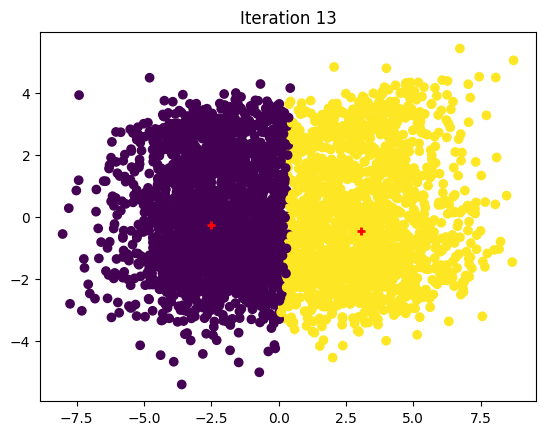

Execution K-Means GPU run #1: 1.090949431003537; curr avg: 1.090949431003537; 
 
Avg exec K-Means GPU: 1.090949431003537
Max exec K-Means GPU: 1.090949431003537
Min exec time K-Means GPU: 1.090949431003537


In [139]:

# * ####################################
# * Rodando o K-Means GPU
# * ####################################

""" NUMBER_OF_RUNS = 10

totalExecTime = 0.0
slowestExecTime = -1.0
fastestExecTime = FLOAT_MAX

totalHits = 0
totalHitsTime = 0.0

for rep in range(1, NUMBER_OF_RUNS + 1):
    startTime = time.time()
    results = km.kMeansGPU(datasetTreated, k=K, maxIter=MAX_ITERATIONS, printIter=False, plotResults=PLOT_RESULTS, debug=DEBUG)
    elapsedTime = time.time() - startTime
    if elapsedTime < fastestExecTime: fastestExecTime = elapsedTime
    if elapsedTime > slowestExecTime: slowestExecTime = elapsedTime
    totalExecTime += elapsedTime
    print(f'Execution K-Means GPU run #{rep}: {elapsedTime}; curr avg: {totalExecTime / rep}; ', end='')

    # Verificando acertos
    # Converting from numpy arrays to panda's dataframes, if needed
    if results.__class__.__name__ != pd.DataFrame.__class__.__name__: results = pd.DataFrame(results)
    startTime = time.time()
    hits, _, _  = km.getClassificationHits(results, dataset, classColumnName, classes, debug=DEBUG)
    elapsedTime = time.time() - startTime
    totalHits += hits
    totalHitsTime += elapsedTime
    print(f'Hits: {hits} (done in {elapsedTime:.4f}); curr avg hits: {totalHits / rep}\n')

print(f' \nAvg exec K-Means GPU: {totalExecTime / NUMBER_OF_RUNS}')
print(f'Max exec K-Means GPU: {slowestExecTime}')
print(f'Min exec time K-Means GPU: {fastestExecTime}')

print(f' \nAverage hits: {totalHits / NUMBER_OF_RUNS}')
print(f'Avg exec K-Means GPU classificationHits(): {totalHitsTime / NUMBER_OF_RUNS}') """

runTests('GPU', 100, TEST_CORRECTEDNESS)

### Dataset 2 (N > 10.000, D = 8, K = 2) — HTRU2

Foi utilizado aqui o Dataset **[HTRU2 (High Time Resolution Universe 2)](https://archive.ics.uci.edu/dataset/372/htru2)**, que reúne dados a respeito de emissões de sinais de rádio de banda larga obtidos através de leituras feitas com telescópios de rádio. É um dos resultados da busca por pulsares, estrelas de neutrôn que possuem uma rotação rápida e que emitem sinais de rádio banda larga detectáveis do nosso planeta. Temos **8 variáveis (D = 8)** e **17.898 instâncias**.

Esse dataset também contém informações de classe, definindo se a leitura é **positiva** ou **negativa**, a respeito do sinal candidato de fato originar ou não de um pulsar. Portanto, haverão **2 grupos de dados (K = 2)**.

Esse conjunto de dados está presente no arquivo `HTRU_2.csv` dentro do arquivo `HTRU_2.zip` do dataset (também disponível em download direto [neste link](https://archive.ics.uci.edu/static/public/372/htru2.zip)).

#### Código

In [140]:
# Novas variáveis globais
K = 2
MAX_ITERATIONS = 60
PLOT_RESULTS = False
DEBUG = False

datasetFilePath = './htru2/HTRU_2.csv'

columnNames = ['mean_IP', 'std_dev_IP', 'exc_kurt_IP', 'skew_IP', 'mean_DM_SNR', 'std_dev_DM_SNR', 'exc_kurt_DM_SNR', 'skew_DM_SNR', 'is_positive']

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames, sep=',')

datasetTreated = dataset.drop(columns=['is_positive'])
print(datasetTreated)

classColumnName = 'is_positive'
classes = dataset[classColumnName].unique()

print(f'Classes (from column "{classColumnName}"): {classes}')

          mean_IP  std_dev_IP  exc_kurt_IP   skew_IP  mean_DM_SNR   
0      140.562500   55.683782    -0.234571 -0.699648     3.199833  \
1      102.507812   58.882430     0.465318 -0.515088     1.677258   
2      103.015625   39.341649     0.323328  1.051164     3.121237   
3      136.750000   57.178449    -0.068415 -0.636238     3.642977   
4       88.726562   40.672225     0.600866  1.123492     1.178930   
...           ...         ...          ...       ...          ...   
17893  136.429688   59.847421    -0.187846 -0.738123     1.296823   
17894  122.554688   49.485605     0.127978  0.323061    16.409699   
17895  119.335938   59.935939     0.159363 -0.743025    21.430602   
17896  114.507812   53.902400     0.201161 -0.024789     1.946488   
17897   57.062500   85.797340     1.406391  0.089520   188.306020   

       std_dev_DM_SNR  exc_kurt_DM_SNR  skew_DM_SNR  
0           19.110426         7.975532    74.242225  
1           14.860146        10.576487   127.393580  
2        

In [141]:
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((datasetTreated - datasetTreated.min()) / (datasetTreated.max() - datasetTreated.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
        mean_IP  std_dev_IP  exc_kurt_IP   skew_IP  mean_DM_SNR   
0      7.492075    4.759187     2.485386  1.140645     1.120440  \
1      5.658651    5.148176     3.118736  1.164410     1.059040   
2      5.683117    2.771815     2.990246  1.366092     1.117270   
3      7.308394    4.940954     2.635746  1.148810     1.138310   
4      4.994689    2.933627     3.241398  1.375405     1.038944   
...         ...         ...          ...       ...          ...   
17893  7.292961    5.265529     2.527670  1.135690     1.043698   
17894  6.624482    4.005425     2.813468  1.272336     1.653146   
17895  6.469407    5.276293     2.841869  1.135059     1.855621   
17896  6.236795    4.542553     2.879693  1.227544     1.069897   
17897  3.469156    8.421307     3.970340  1.242264     8.585104   

       std_dev_DM_SNR  exc_kurt_DM_SNR  skew_DM_SNR  
0            2.023125         3.654872     1.575009  
1            1.652719   

In [10]:

# * ####################################
# * Rodando o K-Means CPU
# * ####################################

runTests('CPU', 100, TEST_CORRECTEDNESS)

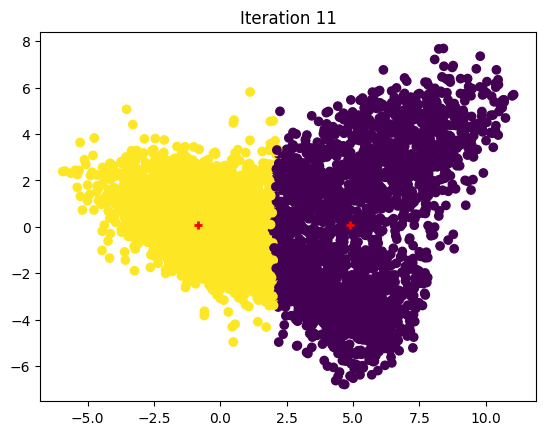

Execution K-Means GPU run #1: 1.9909552610188257; curr avg: 1.9909552610188257; 
 
Avg exec K-Means GPU: 1.9909552610188257
Max exec K-Means GPU: 1.9909552610188257
Min exec time K-Means GPU: 1.9909552610188257


In [143]:

# * ####################################
# * Rodando o K-Means GPU
# * ####################################

runTests('GPU', 100, TEST_CORRECTEDNESS)

### Dataset 3 (N > 100.000, D = 50, K = 2) — MiniBooNE

Foi utilizado aqui o Dataset **[MiniBooNE Particle Identification](https://archive.ics.uci.edu/dataset/199/miniboone+particle+identification)**, que reúne dados a respeito de partículas detectadas no experimento *MiniBooNE* (*Mini Booster Neutrino Experiment*), conduzido no laboratório americano *Fermilab*. Cada detecção de partícula é descrita por **50 variáveis reais (D = 50)** e há **129.596 instâncias no total**.

As primeiras 36.488 instâncias são detecções de neutrinos do elétron (sinal) e as 93.108 restantes são de neutrinos do múon (ruído de fundo). Assim, as informações de classe desse dataset estão implícitas, expressa pela ordem das instâncias no arquivo. Como temos duas classes, haverão **2 grupos de dados (K = 2)**.

Esse conjunto de dados está presente no arquivo `MiniBooNE_PID.txt` dentro do arquivo `miniboone+particle+identification.zip` do dataset (também disponível em download direto [neste link](https://archive.ics.uci.edu/static/public/199/miniboone+particle+identification.zip)).

Foi necessário, neste dataset, realizar um **pré-processamento** para **remoção de outliers**. Originalmente, há 130.064 instâncias no total (36.499 sinal e 93.565 ruído). Porém, existem 468 instâncias (11 sinal e 457 ruído) que são extremos outliers, possuindo o valor -999.0 em todas as 50 variáveis — provavelmente advindos de algum erro de detecção. A presença destes outliers causava a criação de um cluster contendo apenas estes outliers, diminuindo muito o tempo de execução do algoritmo de maneira artificial. Estes outliers tiveram que ser removidos. Note que poderíamos ter solucionado este problema com outra abordagem: aumentar K para 3, criando um cluster novo para conter apenas os outliers. Isso, no entanto, seria mais custoso computacionalmente do que a remoção das instâncias.

#### Código

In [74]:
# Novas variáveis globais
K = 2
MAX_ITERATIONS = 60
PLOT_RESULTS = False
DEBUG = False

COMMENT_CHAR = '#'

# As primeiras 36.499 instâncias são consideradas um sinal, e o resto como ruído
N_OF_SIGNAL_LINES = 36499

datasetFilePath = './MiniBooNE_PID.csv'

# Processando o aqruivo .txt file e convertendo para um arquivo .csv válido (com a primeira linha comentada, removendo o leading whitespace, e trocando o separador de "  " ou " " para ",")
if not os.path.exists(datasetFilePath):
    with \
        open('./MiniBooNE_PID.txt', 'r') as file,\
        open(datasetFilePath, 'w') as fileNew:

        print('Processing MiniBooNE_PID.txt...\n ')

        # Removendo outliers com -999.0 de valor nas 50 variáveis. Há 468 destas instâncias
        outlierString = '''-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03'''

        index = 1
        signalInstRemoved = 0
        noiseInstRemoved = 0
        for line in file:
            if index != 1:
                lineToWrite = line.strip(' ').replace('  ', ' ').replace(' ', ',')
                if outlierString not in lineToWrite:
                    fileNew.write(lineToWrite)
                else:
                    if index - 1 <= N_OF_SIGNAL_LINES:
                        # print(f'Instance (signal) #{index - 1} removed...')
                        signalInstRemoved += 1
                    else:
                        # print(f'Instance (noise) #{index - 1} removed...')
                        noiseInstRemoved += 1
            # else:
            #     fileNew.write(COMMENT_CHAR + ' ' + line.strip(' ').replace('  ', ' '))
            index += 1

        print(f'Signal outlier instances removed = {signalInstRemoved}')
        print(f'Noise outlier instances removed = {noiseInstRemoved}\n ')

        print(f'Processed dataset saved in {datasetFilePath} with success!\n ')
else:
    print(f'Processed dataset found in {datasetFilePath}. No need for processing!\n ')

columnNames = [f'id_var_{i}' for i in range(1, 50 + 1) ]

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFile, names=columnNames, sep=',', skip_blank_lines=True)

# Gerando coluna de classes
classColumn = pd.DataFrame(['signal' if idx <= 36488 else 'noise' for idx in range(1, len(dataset) + 1)])
# print(classColumn)

classColumnName = 'class'
dataset.insert(len(dataset.columns), classColumnName, classColumn)
del classColumn

datasetTreated = dataset.drop(columns=[classColumnName])
print(datasetTreated)

classes = ['signal', 'noise']
print(f'Classes (from column "{classColumnName}"): {classes}')

Processed dataset found in ./MiniBooNE_PID.csv. No need for processing!
 
        id_var_1  id_var_2  id_var_3  id_var_4  id_var_5  id_var_6  id_var_7   
0        2.59413  0.468803   20.6916  0.322648  0.009682  0.374393  0.803479  \
1        3.86388  0.645781   18.1375  0.233529  0.030733  0.361239  1.069740   
2        3.38584  1.197140   36.0807  0.200866  0.017341  0.260841  1.108950   
3        4.28524  0.510155  674.2010  0.281923  0.009174  0.000000  0.998822   
4        5.93662  0.832993   59.8796  0.232853  0.025066  0.233556  1.370040   
...          ...       ...       ...       ...       ...       ...       ...   
129591   4.80718  1.451020  174.6920  0.343481  0.002174  0.000000  0.747401   
129592   5.00527  1.501860  129.9270  0.273477  0.006098  0.109769  1.325370   
129593   3.10842  2.178140   56.3651  0.211850  0.000000  0.167382  1.318900   
129594   5.44560  1.845700  103.4630  0.287411  0.015929  0.107495  0.679931   
129595   4.55062  1.341740   80.0887  0.283594

In [75]:
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((datasetTreated - datasetTreated.min()) / (datasetTreated.max() - datasetTreated.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
        id_var_1  id_var_2  id_var_3  id_var_4  id_var_5  id_var_6  id_var_7   
0       2.368749  1.421131  1.039201  4.103207  5.452597  5.787233  2.158663  \
1       3.038712  1.603309  1.034359  2.834322  6.017928  5.619037  2.542627   
2       2.786482  2.170867  1.068374  2.369263  5.658285  4.335283  2.599170   
3       3.261035  1.463698  2.278040  3.523361  5.438966  1.000000  2.440359   
4       4.132359  1.796021  1.113489  2.824697  5.865742  3.986399  2.975677   
...          ...       ...       ...       ...       ...       ...       ...   
129591  3.536428  2.432206  1.331135  4.399829  5.250969  1.000000  2.077796   
129592  3.640947  2.484539  1.246275  3.403106  5.356339  2.403578  2.911261   
129593  2.640106  3.180688  1.106826  2.525655  5.192588  3.140255  2.901930   
129594  3.873280  2.838481  1.196108  3.601499  5.620371  2.374501  1.980500   
129595  3.401059  2.319715  1.151798  3.547153  5.192588 

In [14]:

# * ####################################
# * Rodando o K-Means CPU
# * ####################################

runTests('CPU', 50, TEST_CORRECTEDNESS)

In [77]:

# * ####################################
# * Rodando o K-Means GPU
# * ####################################

runTests('GPU', 50, TEST_CORRECTEDNESS)

    Time to initialize variables and random centroids: 0.0006875700000000001 s
    Time to convert dataset and centroids to Numpy arrays: 0.0008654890000000001 s
    Time to compute calcLogs(): 0.011857797000000002 s
    Time to run 6 iterations of K-Means GPU: 0.304779513 s. Avg per iteration: 0.0507965855
        Average time per iteration to run calcDistances(): 0.006693799833333333 s. Total time: 0.040162799000000006 s
        Average time per iteration to run calcClosestCentroids(): 0.001390276666666667 s. Total time: 0.00834166 s
        Average time per centroid per iteration to calculate new centroids: 0.021324909583333333 s. Total time: 0.255898915 s
Execution K-Means GPU run #1: 0.36508979101199657; curr avg: 0.36508979101199657; 
    Time to initialize variables and random centroids: 0.0006723790000000001 s
    Time to convert dataset and centroids to Numpy arrays: 0.000669919 s
    Time to compute calcLogs(): 0.010699609 s
    Time to run 42 iterations of K-Means GPU: 2.262

### Dataset 4 (N > 1.000.000, D = 8) — WESAD

Foi utilizado aqui um sub-conjunto dos dados do Dataset **[WESAD (Wearable Stress and Affect Detection)](https://archive.ics.uci.edu/dataset/465/wesad+wearable+stress+and+affect+detection)**, que reúne dados, fisiológicos e de movimento, de diversos sensores presentes em aparelhos *wearables* usados por 15 pacientes diferentes em testes laboratoriais. Um aparelho foi usado no peitoral e outro no pulso dos pacientes.

Esse dataset também contém informações de classe, definindo momentos dos testes como pertencendo à três classificações de emoção do paciente: **referência**, **estresse** ou **diversão**. Portanto, haverão **3 grupos de dados (K = 3)**.

O sub-conjunto de dados utilizado foi: dados obtidos apenas através do **aparelho usado no peito** do paciente, e apenas do **paciente #4**. Utilizando este sub-conjunto, temos **8 variáveis (D = 8)** e **4.588.552 instâncias**, cada uma sendo uma leitura ao longo do tempo do teste laboratorial (leituras realizadas na frequência de 700hz).

Esse sub-conjunto de dados está presente no arquivo `S4/S4_respiban.txt` dentro do arquivo `WESAD.zip` do dataset (também disponível em download direto [neste link](https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download)).

#### Código

In [99]:
# Novas variáveis globais
K = 3
MAX_ITERATIONS = 60
PLOT_RESULTS = False
DEBUG = False

datasetFilePath = './WESAD/S4/S4_respiban.txt'
columnNames = ['index', 'DI', 'ECG', 'EDA', 'EMG', 'TEMP', 'spatialX', 'spatialY', 'spatialZ', 'RESPIRATION', '_ignore_']

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames, sep='\t', index_col=0, skip_blank_lines=True, comment='#')

# datasetTreated = dataset.drop(columns=['DI', '_ignore_'])
# print(datasetTreated)

# classColumnName = 'DI'
# classes = dataset[classColumnName].unique()

# print(f'Classes (from column "{classColumnName}"): {classes}')

# Gerando coluna de classes
classColumn = []
for idx in range(len(dataset)):
    classification = None
    if idx < 1329300: classification = 'base'
    elif idx < 1926400: classification = 'fun'
    elif idx < 2563400: classification = 'base' # Medi 1
    elif idx < 4020100: classification = 'stress'
    else: classification = 'base' # Medi 2

    classColumn.append(classification)
classColumn = pd.DataFrame(classColumn)
print(classColumn)

classColumnName = 'class'
dataset.insert(len(dataset.columns), classColumnName, classColumn)
del classColumn

datasetTreated = dataset.drop(columns=['DI', '_ignore_', classColumnName])
print(datasetTreated)

classes = ['base', 'fun', 'stress']
print(f'Classes (from column "{classColumnName}"): {classes}')

            0
0        base
1        base
2        base
3        base
4        base
...       ...
4588548  base
4588549  base
4588550  base
4588551  base
4588552  base

[4588553 rows x 1 columns]
           ECG   EDA    EMG   TEMP  spatialX  spatialY  spatialZ  RESPIRATION
index                                                                        
0        34487  2844  32819  27563     37495     32437     31921        33292
1        34274  2869  32481  27560     37485     32433     31935        33295
2        33960  2774  32431  27557     37471     32445     31927        33293
3        33737  2767  32561  27555     37485     32433     31925        33308
4        33602  2768  32696  27562     37487     32429     31909        33300
...        ...   ...    ...    ...       ...       ...       ...          ...
4588548  33272  6470  32721  26727     37539     32597     32256        31863
4588549  33389  6467  32360  26726     37543     32583     32253        31865
4588550  33497  6456  32

In [100]:
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((datasetTreated - datasetTreated.min()) / (datasetTreated.max() - datasetTreated.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
              ECG       EDA       EMG      TEMP  spatialX  spatialY  spatialZ   
index                                                                           
0        5.735295  1.508909  4.175522  8.925593  5.800000  5.203079  4.600799  \
1        5.706038  1.527215  3.927640  8.903516  5.789437  5.196481  4.607789   
2        5.662907  1.457652  3.890971  8.881439  5.774648  5.216276  4.603795   
3        5.632276  1.452526  3.986310  8.866721  5.789437  5.196481  4.602796   
4        5.613733  1.453258  4.085316  8.918234  5.791549  5.189883  4.594808   
...           ...       ...       ...       ...       ...       ...       ...   
4588548  5.568405  4.164022  4.103651  2.773508  5.846479  5.467009  4.768057   
4588549  5.584475  4.161826  3.838902  2.766149  5.850704  5.443915  4.766559   
4588550  5.599310  4.153771  3.836701  2.714636  5.836972  5.468658  4.761567   
4588551  5.599585  4.149378  3.703227  2.81766

In [18]:

# * ####################################
# * Rodando o K-Means CPU
# * ####################################

runTests('CPU', 5, TEST_CORRECTEDNESS)

In [103]:

# * ####################################
# * Rodando o K-Means GPU
# * ####################################

runTests('GPU', 5, TEST_CORRECTEDNESS)

    Time to initialize variables and random centroids: 0.00047730000000000005 s
    Time to convert dataset and centroids to Numpy arrays: 0.00073886 s
    Time to compute calcLogs(): 0.053117943 s
    Time to run 13 iterations of K-Means GPU: 2.4012498520000003 s. Avg per iteration: 0.1847115270769231
        Average time per iteration to run calcDistances(): 0.04145905761538462 s. Total time: 0.538967749 s
        Average time per iteration to run calcClosestCentroids(): 0.019446453615384617 s. Total time: 0.252803897 s
        Average time per centroid per iteration to calculate new centroids: 0.04125496682051283 s. Total time: 1.608943706 s
Execution K-Means GPU run #1: 2.5087434780143667; curr avg: 2.5087434780143667; 
    Time to initialize variables and random centroids: 0.00044510000000000003 s
    Time to convert dataset and centroids to Numpy arrays: 0.0006137590000000001 s
    Time to compute calcLogs(): 0.051386205000000004 s
    Time to run 12 iterations of K-Means GPU: 2.

#### Resultados

> Resultados completos disponíveis no arquivo `code/examples-and-tests/speedupTestsRawResults.txt`

| |Tempo médio (50 execuções)|Speedup Médio|
|-|-|-|
|K-Means CPU|~129,81s|-|
|K-Means GPU|~27,87s|~4,65x|

### Dataset 5 (N > 10.000.000, D = 3, K = 7) — HHAR

Foi utilizado aqui um sub-conjunto dos dados do Dataset **[Heterogeneity Human Activity Recognition (HHAR)](https://archive.ics.uci.edu/dataset/344/heterogeneity+activity+recognition)**, que reúne dados de movimento do giroscópio e acelerômetro presentes em aparelhos celulares (*smartphones*) e relógios (*smartwatches*) usados por 9 usuários diferentes ao realizar diversas atividades físicas diferentes ou estando em repouso.

Esse dataset também contém informações de classe, definindo momentos dos testes como pertencendo a uma de seis atividades realizadas: **ciclismo**, **repouso (sentado)**, **repouso (em pé)**, **andar**, **subir escadas** e **descer escadas**. Além disto, há uma sétima "atividade", **nula**, que representa espaços do teste onde não foi realizada nenhuma atividade. Portanto, haverão **7 grupos de dados (K = 7)**.

O sub-conjunto de dados utilizado foi: dados obtidos apenas através do **giroscópio do smartphone** do usuário. Utilizando este sub-conjunto, temos **3 variáveis (D = 3)** e **13.932.632 instâncias**, cada uma sendo uma leitura ao longo do tempo do experimento.

Esse sub-conjunto de dados está presente no arquivo `Activity recognition exp/Phones_gyroscope.csv` dentro do arquivo `heterogeneity+activity+recognition.zip` do dataset (também disponível em download direto [neste link](https://archive.ics.uci.edu/static/public/344/heterogeneity+activity+recognition.zip)).

#### Código

In [104]:
# Novas variáveis globais
K = 7
MAX_ITERATIONS = 60
PLOT_RESULTS = False
DEBUG = False

datasetFilePath = './heterogeneity+activity+recognition/Activity recognition exp/Phones_gyroscope.csv'
columnNames = ['index', 'arrival_time', 'creation_Time', 'x', 'y', 'z', 'user', 'model', 'device', 'gt']

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFile, names=columnNames, header=0, sep=',', index_col=0)

datasetTreated = dataset.drop(columns=['arrival_time', 'creation_Time', 'user', 'model', 'device', 'gt'])
print(datasetTreated)

classColumnName = 'gt'
classes = dataset[classColumnName].unique()

print(f'Classes (from column "{classColumnName}"): {classes}')

              x         y         z
index                              
0      0.013748 -0.000626 -0.023376
1      0.014816 -0.001694 -0.022308
2      0.015884 -0.001694 -0.021240
3      0.016953 -0.003830 -0.020172
4      0.015884 -0.007034 -0.020172
...         ...       ...       ...
11306 -0.046844  0.337667  0.134677
11307 -0.117598  0.221777  0.131749
11308 -0.177617  0.056115  0.095152
11309 -0.195183 -0.124429  0.063191
11310 -0.162002 -0.208846  0.043184

[13932632 rows x 3 columns]
Classes (from column "gt"): ['stand' nan 'sit' 'walk' 'stairsup' 'stairsdown' 'bike']


In [105]:
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((datasetTreated - datasetTreated.min()) / (datasetTreated.max() - datasetTreated.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
              x         y         z
index                              
0      3.820436  4.219502  5.217352
1      3.821163  4.219072  5.218209
2      3.821890  4.219072  5.219066
3      3.822618  4.218211  5.219923
4      3.821890  4.216920  5.219923
...         ...       ...       ...
11306  3.779176  4.355790  5.344196
11307  3.730996  4.309101  5.341846
11308  3.690126  4.242361  5.312475
11309  3.678164  4.169625  5.286825
11310  3.700759  4.135616  5.270769

[13932632 rows x 3 columns]


In [22]:

# * ####################################
# * Rodando o K-Means CPU
# * ####################################

runTests('CPU', 1, TEST_CORRECTEDNESS)

Execution K-Means CPU run #1: 1440.225573489006; curr avg: 1440.225573489006; Hits: 3944386 (done in 18402.0538); curr avg hits: 3944386.0
 
Avg exec K-Means CPU: 1440.225573489006
Max exec K-Means CPU: 1440.225573489006
Min exec time K-Means CPU: 1440.225573489006
 
Average hits: 3944386.0
Avg exec K-Means CPU classificationHits(): 18402.05382272901


In [111]:

# * ####################################
# * Rodando o K-Means GPU
# * ####################################

runTests('GPU', 1, TEST_CORRECTEDNESS)

    Time to initialize variables and random centroids: 0.0010694090000000001 s
    Time to convert dataset and centroids to Numpy arrays: 0.0007110500000000001 s
    Time to compute calcLogs(): 0.066248318 s
    Time to run 54 iterations of K-Means GPU: 34.929681891 s. Avg per iteration: 0.6468459609444445
        Average time per iteration to run calcDistances(): 0.15689362603703705 s. Total time: 8.472255806 s
        Average time per iteration to run calcClosestCentroids(): 0.0676841002962963 s. Total time: 3.654941416 s
        Average time per centroid per iteration to calculate new centroids: 0.05853480163227514 s. Total time: 22.126155017000002 s
Execution K-Means GPU run #1: 35.129185215977486; curr avg: 35.129185215977486; 
    Time to initialize variables and random centroids: 0.0017835890000000001 s
    Time to convert dataset and centroids to Numpy arrays: 0.029634651 s
    Time to compute calcLogs(): 0.05736253400000001 s
    Time to run 56 iterations of K-Means GPU: 36.09